# Forecasting with real world data

Daily Minimum Temperatures in Melbourne  - (https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv) dataset contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990.

In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
TEMPERATURES_CSV = './data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Parsing the raw data

In [4]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter=",")
        count = 0
        next(reader)
        for row in reader:
            times.append(count)
            temperatures.append(float(row[1]))
            count = count + 1
        print(count)
       
    return times, temperatures


3650


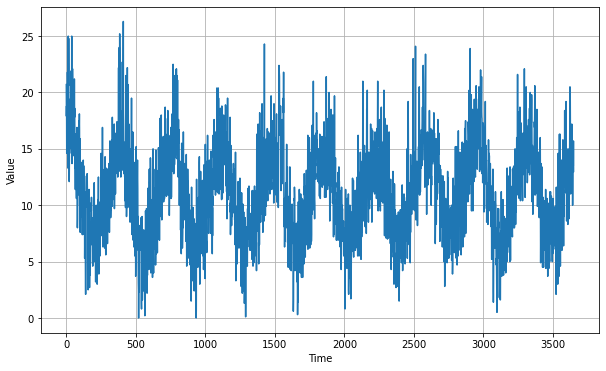

In [5]:
@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

In [6]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [7]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Applying transformations
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture

In [10]:
def create_uncompiled_model():

     model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, activation='relu', input_shape=[None,1]),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x*35)
    ]) 

     return model

In [11]:
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Your current architecture is compatible with the windowed dataset! :)


In [12]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
    
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [13]:
# Run training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 [==============================] - 7s 57ms/step - loss: 2.0985 - mae: 2.5558 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - 4s 57ms/step - loss: 1.7698 - mae: 2.2202 - lr: 1.1220e-04
Epoch 3/100
77/77 [==============================] - 4s 56ms/step - loss: 1.8230 - mae: 2.2736 - lr: 1.2589e-04
Epoch 4/100
77/77 [==============================] - 4s 57ms/step - loss: 1.6839 - mae: 2.1325 - lr: 1.4125e-04
Epoch 5/100
77/77 [==============================] - 4s 55ms/step - loss: 1.7463 - mae: 2.1965 - lr: 1.5849e-04
Epoch 6/100
77/77 [==============================] - 4s 55ms/step - loss: 1.6706 - mae: 2.1214 - lr: 1.7783e-04
Epoch 7/100
77/77 [==============================] - 4s 56ms/step - loss: 1.7183 - mae: 2.1675 - lr: 1.9953e-04
Epoch 8/100
77/77 [==============================] - 4s 55ms/step - loss: 1.6722 - mae: 2.1220 - lr: 2.2387e-04
Epoch 9/100
77/77 [==============================] - 4s 55ms/step - loss: 1.7676 - mae: 2.2142 - lr: 2.5

(0.0001, 10.0, 0.0, 10.0)

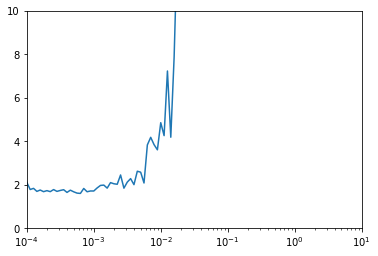

In [14]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

## Compiling the model

In [16]:
def create_model():

    
    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=6.3096e-04, momentum=0.9),
                  metrics=["mae"])  
    

    return model

In [17]:
model = create_model()

history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 [==============================] - 7s 58ms/step - loss: 2.5433 - mae: 3.0067
Epoch 2/50
77/77 [==============================] - 4s 57ms/step - loss: 2.0788 - mae: 2.5397
Epoch 3/50
77/77 [==============================] - 4s 57ms/step - loss: 1.8060 - mae: 2.2558
Epoch 4/50
77/77 [==============================] - 5s 57ms/step - loss: 1.8077 - mae: 2.2604
Epoch 5/50
77/77 [==============================] - 4s 57ms/step - loss: 1.6748 - mae: 2.1216
Epoch 6/50
77/77 [==============================] - 4s 57ms/step - loss: 1.7780 - mae: 2.2328
Epoch 7/50
77/77 [==============================] - 4s 56ms/step - loss: 1.6791 - mae: 2.1282
Epoch 8/50
77/77 [==============================] - 5s 58ms/step - loss: 1.6176 - mae: 2.0635
Epoch 9/50
77/77 [==============================] - 4s 57ms/step - loss: 1.7886 - mae: 2.2392
Epoch 10/50
77/77 [==============================] - 4s 57ms/step - loss: 1.5787 - mae: 2.0203
Epoch 11/50
77/77 [==============================] - 5s 58m

## Evaluating

In [18]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

## Faster model forecasts

In [19]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

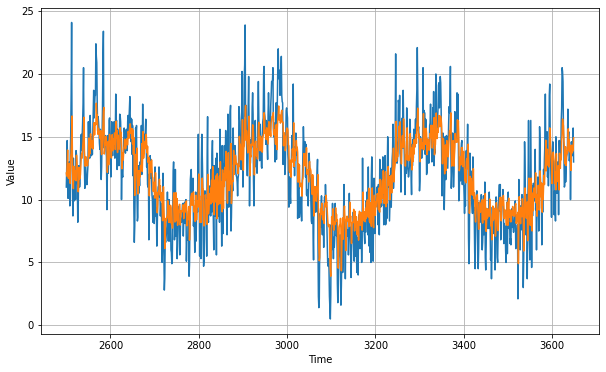

In [20]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [21]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.43, mae: 1.82 for forecast


In [22]:
model.save('saved_model/my_model')

! tar -czvf saved_model.tar.gz saved_model/

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


saved_model/
saved_model/my_model/
saved_model/my_model/keras_metadata.pb
saved_model/my_model/variables/
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/variables/variables.index
saved_model/my_model/saved_model.pb
saved_model/my_model/assets/
